<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/Interpretation4_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting the outputs of the model on the fourth dataset

We first need to load the dataset. 

In [2]:
#@title
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

!pip install flashtorch
from flashtorch.saliency import Backprop

!pip install shap 
import shap

!pip install pytorch-gradcam
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

!wget https://raw.githubusercontent.com/yiskw713/SmoothGradCAMplusplus/master/cam.py -P local_modules -nc
!wget https://raw.githubusercontent.com/yiskw713/SmoothGradCAMplusplus/master/utils/visualize.py -P local_modules -nc
import sys
sys.path.append('local_modules')
from PIL import Image
from local_modules.visualize import visualize
import local_modules.cam as smooth

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/Hshapley2.py -P local_modules -nc
import local_modules.Hshapley2 as HS

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/utils.py -P local_modules -nc
import local_modules.utils as utils

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/interpret.py -P local_modules -nc
import local_modules.interpret as intp

torch.manual_seed(0)

dtype = torch.float

FIGSIZE = (6,5)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
File ‘local_modules/cam.py’ already there; not retrieving.

File ‘local_modules/visualize.py’ already there; not retrieving.

File ‘local_modules/Hshapley2.py’ already there; not retrieving.

File ‘local_modules/utils.py’ already there; not retrieving.

--2020-03-12 15:07:06--  https://raw.githubusercontent.com/lustea0201/Interpretability/master/interpret.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 650 [text/plain]
Saving to: ‘local_modules/interpret.py’

interpret.py        100%[===================>]     650  --.-KB/s    in 0s      

2020-03-12 15:07:06 (127 MB/s) - ‘local_modules/interpret.py’ saved [650/650]



Now, we need to redefine the model, so that we can compute a saliency map for an input image. Then, we also want to load the state_dict of the trained model. 

In [3]:
net = utils.Net() # Model instantiation
# Loading the trained dictionnary state
net.load_state_dict(torch.load('drive/My Drive/Interpretability/model4_random.pth')) 

<All keys matched successfully>

Now, load and format the images we want to test the network's decision on. 

In [0]:
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/5000/data4/random.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

Batch_Size = 64
#transf_temp =  transforms.Compose( [ToTensor()])
#train_data_temp = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf_temp)
#dataloader_temp = DataLoader(train_data_temp, batch_size = Batch_Size, shuffle = True, num_workers = 0)
#MEAN, STD = utils.datasetMeanStd(dataloader_temp)
MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])

transf = transforms.Compose( [ToTensor(), Normalize(mean=MEAN, std=STD)])

train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = Batch_Size, shuffle = False, num_workers = 0)
train_loader = iter(dataloader)

In [0]:
ImF = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/random_4", transform = transf)
batch_Size = 3
exloader = DataLoader(ImF, batch_size = batch_Size, shuffle = False, num_workers = 0)
exIter = iter(exloader)
images, labels = next(exIter)

For this dataset, we should import two images with label 0, because a label 0 can be attributed for two different reasons: 
- absence of a black circle 
- presence of a cross 

Let's first do one with crosses. 

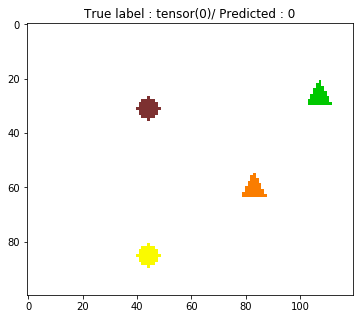

In [6]:
image0 = images[0]
label0 = labels[0]

input0 = image0.view(-1, 3, 100, 120) # This shape is necessary for the network 
outputs = net(input0)
_, predicted0 = torch.max(outputs.data, 1)

img0 = utils.input2image(image0, MEAN, STD)
utils.display_image(img0, label0, int(predicted0))

This image was correctly labeled as a 0, because it contains crosses (even though there is a black circle). 

What parts in the input were considered important by the network to make this call ? 

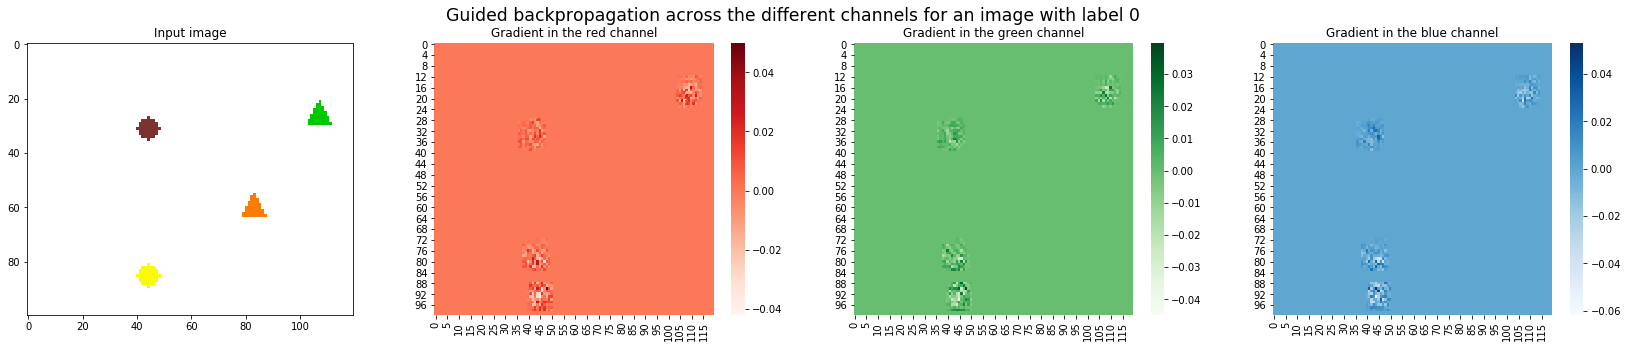

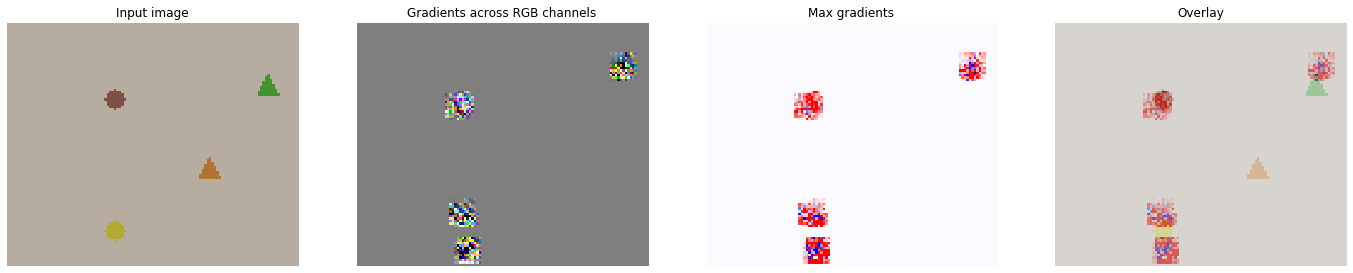

In [9]:
input0.requires_grad = True # Necessary to compute the gradient
backprop = Backprop(net)
gradients0 = backprop.calculate_gradients(input0, label0, guided = True).detach().numpy()
intp.display_gradients(img0, gradients0).suptitle("Guided backpropagation across the different channels for an image with label 0", size="xx-large");
backprop.visualize(input0, label0, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

Crosses and the black circle are most relevant, but the input region of the grey square also seems to matter. There is no color dependence, since black depends as much on the value of each channel. 

Now, one with no black circles.

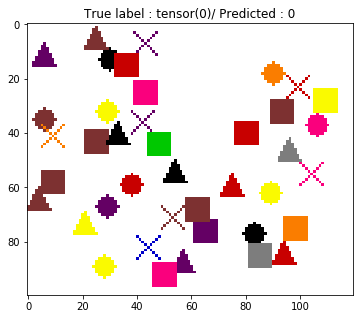

In [10]:
image1 = images[1]
label1 = labels[1]

input1 = image1.view(-1, 3, 100, 120)
outputs = net(input1)
_, predicted1 = torch.max(outputs.data, 1)

img1 = utils.input2image(image1, MEAN, STD)
utils.display_image(img1, label1, int(predicted1))

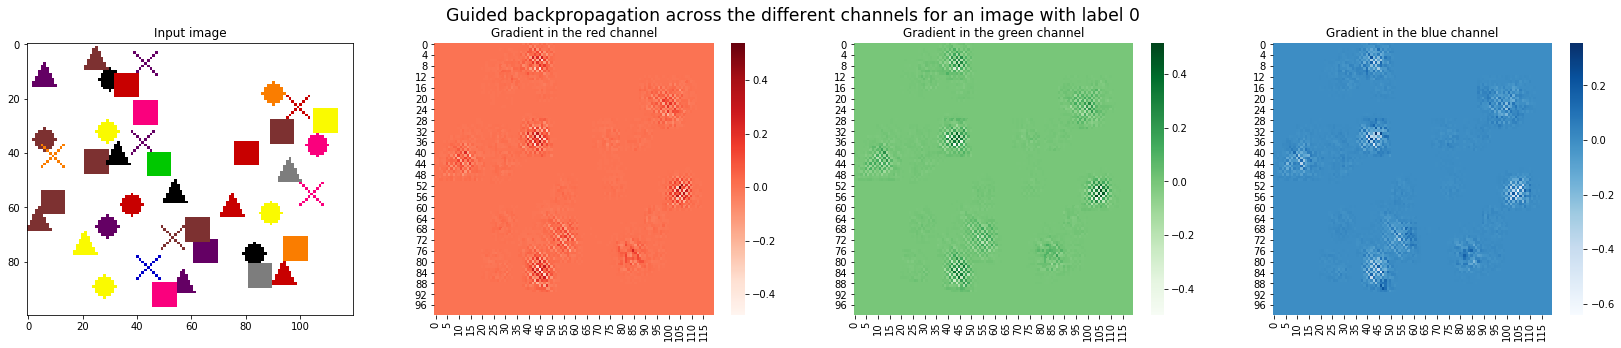

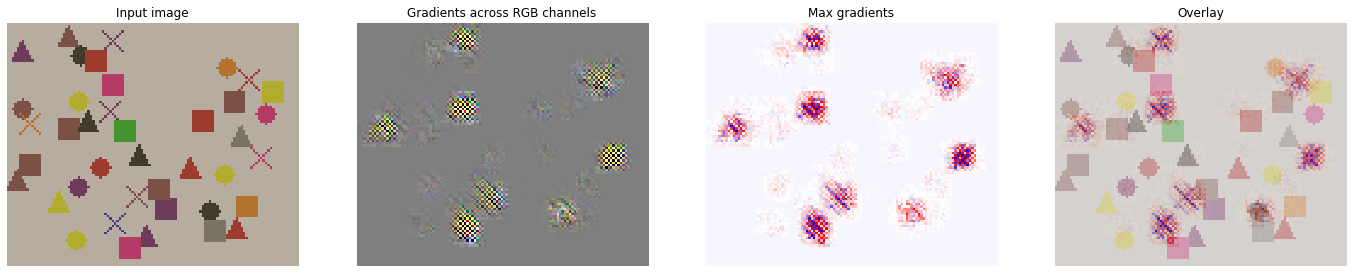

In [11]:
input1.requires_grad = True # Necessary to compute the gradient
backprop = Backprop(net)
gradients1 = backprop.calculate_gradients(input1, label1, guided = True).detach().numpy()
intp.display_gradients(img1, gradients1).suptitle("Guided backpropagation across the different channels for an image with label 0", size="xx-large");
backprop.visualize(input1, label1, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

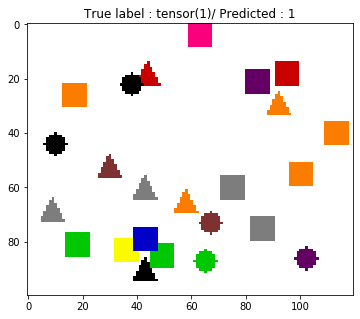

In [12]:
image2 = images[2]
label2 = labels[2]

input2 = image2.view(-1, 3, 100, 120)
outputs = net(input2)
_, predicted2 = torch.max(outputs.data, 1)

img2 = utils.input2image(image2, MEAN, STD)
utils.display_image(img2, label2, int(predicted2))

This image was correctly labeled as a 1, because it contains a black circle but no crosses.

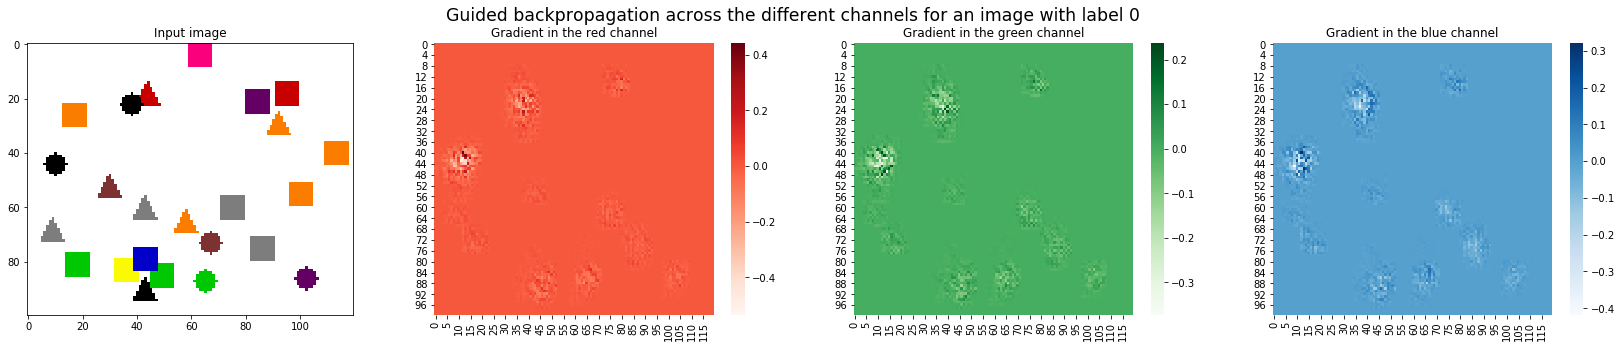

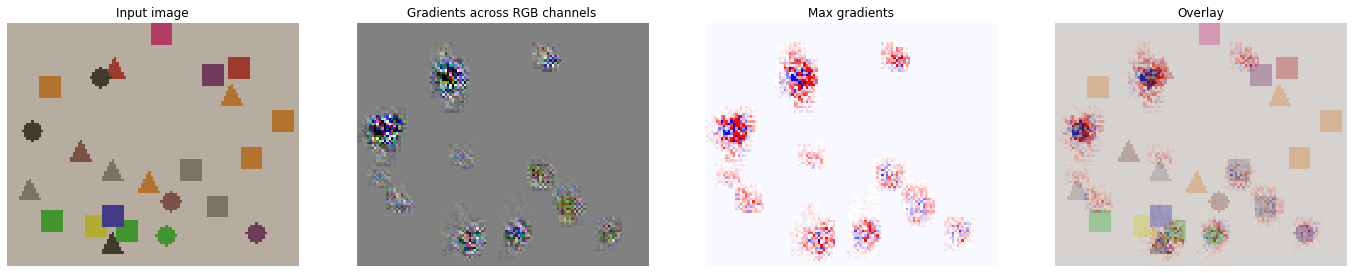

In [13]:
input2.requires_grad = True # Necessary to compute the gradient
backprop = Backprop(net)
gradients2 = backprop.calculate_gradients(input2, label2, guided = True).detach().numpy()
intp.display_gradients(img2, gradients2).suptitle("Guided backpropagation across the different channels for an image with label 0", size="xx-large");
backprop.visualize(input2, label2, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

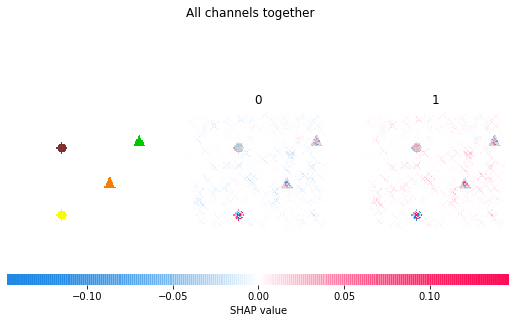

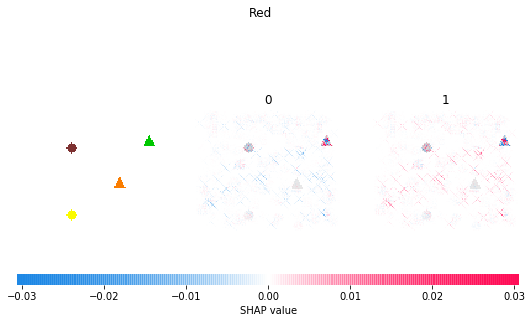

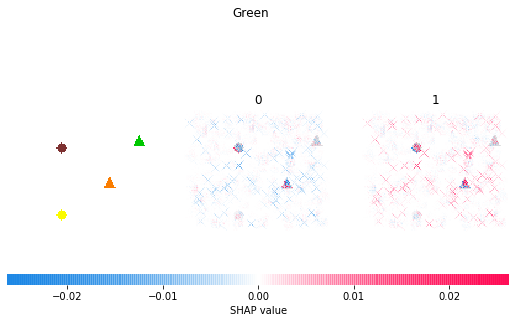

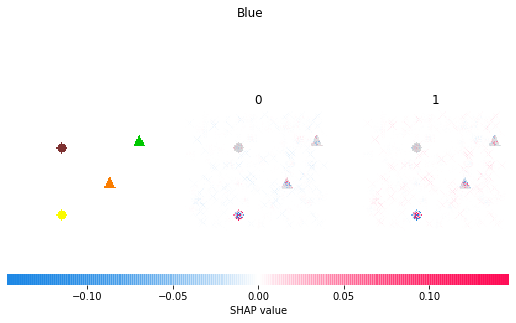

In [38]:

X,Y = next(train_loader)

bg_choice = None # Default: entire training set, "average", "white", "black" 
# Median would result in white 

background = X

if (bg_choice == "black"): 
  background = -torch.ones(X.shape)
elif (bg_choice == "white"): 
  background = torch.ones(X.shape)
elif (bg_choice == "average"): 
  avg = torch.mean(X, dim = 0)
  display_image(avg, 0)



e = shap.GradientExplainer(net, background)

def ShapExp(E, inp):
  shap_values,indexes = E.shap_values(inp, ranked_outputs=2, nsamples=200)

  shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

  to_explain = np.swapaxes(inp,1,2)
  to_explain = np.swapaxes(to_explain,2,3)

  images_plot = utils.denormalize(to_explain.numpy(), MEAN, STD)

  shap_red = [shap_values[0][:,:,:,0], shap_values[1][:,:,:,0]]
  shap_green = [shap_values[0][:,:,:,1], shap_values[1][:,:,:,1]]
  shap_blue = [shap_values[0][:,:,:,2], shap_values[1][:,:,:,2]]

  shap.image_plot(shap_values, images_plot, indexes.numpy(), show = False)
  plt.suptitle("All channels together");
  shap.image_plot(shap_red, images_plot, indexes.numpy(), show = False)
  plt.suptitle("Red");
  shap.image_plot(shap_green, images_plot, indexes.numpy(), show = False)
  plt.suptitle("Green");
  shap.image_plot(shap_blue, images_plot, indexes.numpy(), show = False)
  plt.suptitle("Blue");

ShapExp(e, input0.detach())
ShapExp(e, input1.detach())
ShapExp(e, input2.detach())

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.


Second convolutional layer
Second pooling layer


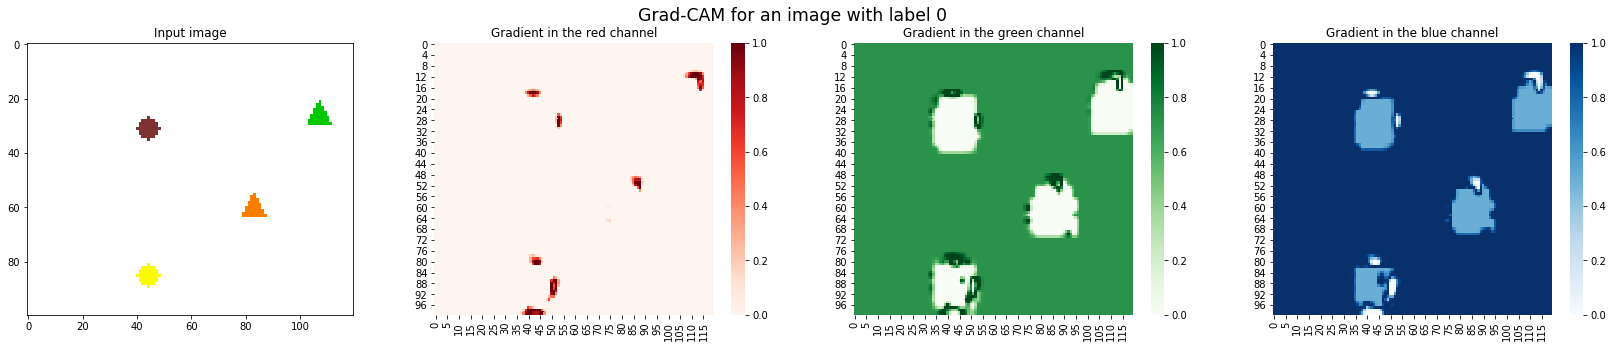

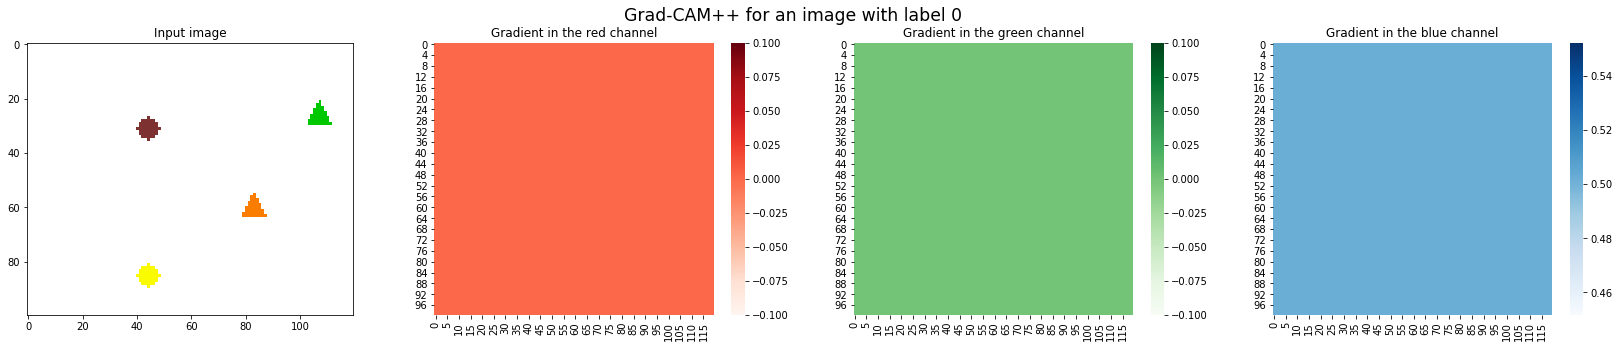

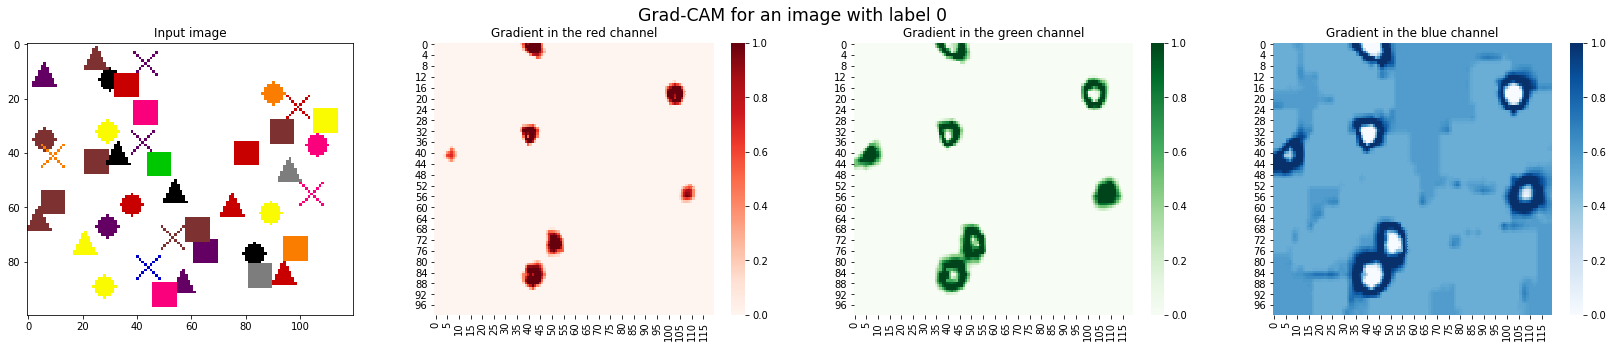

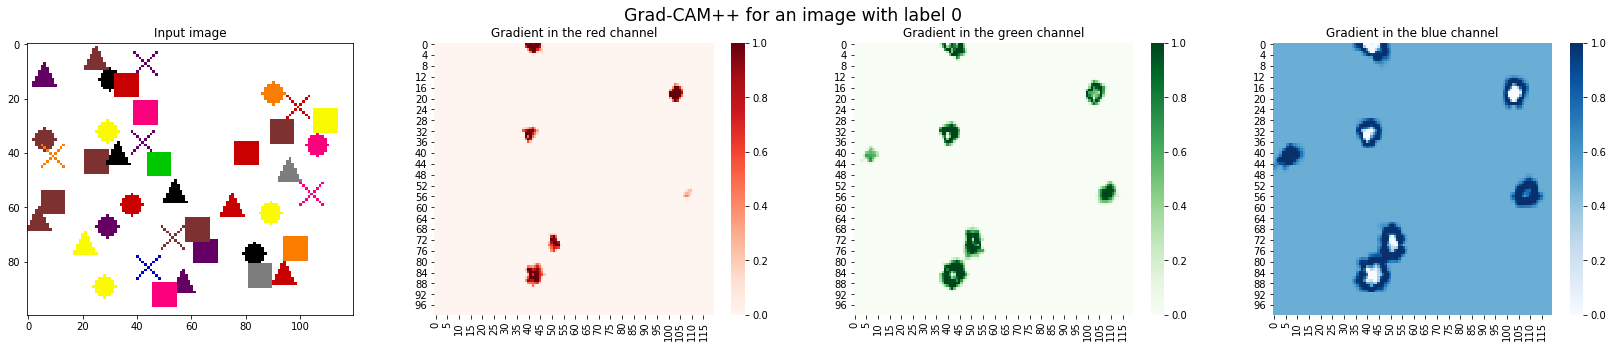

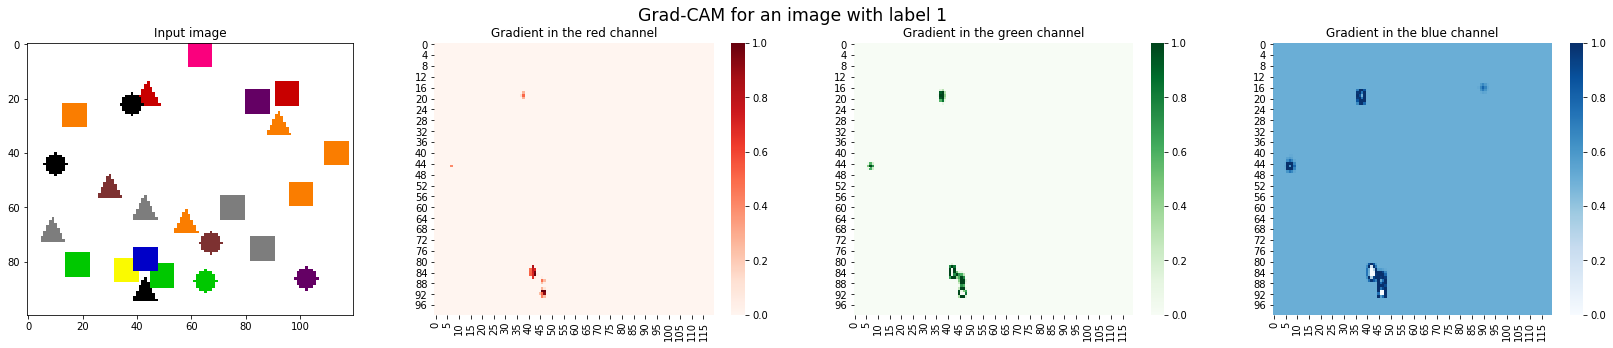

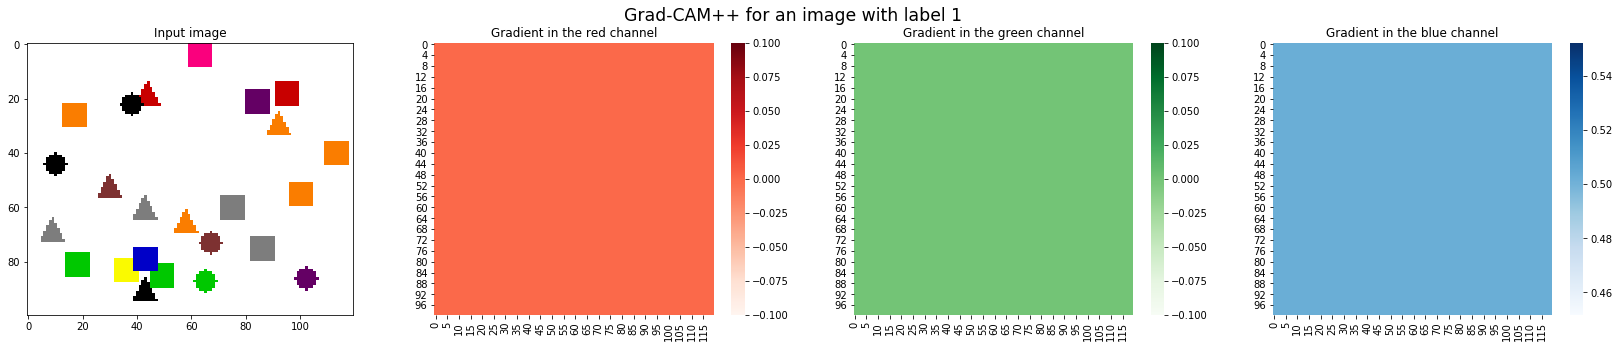

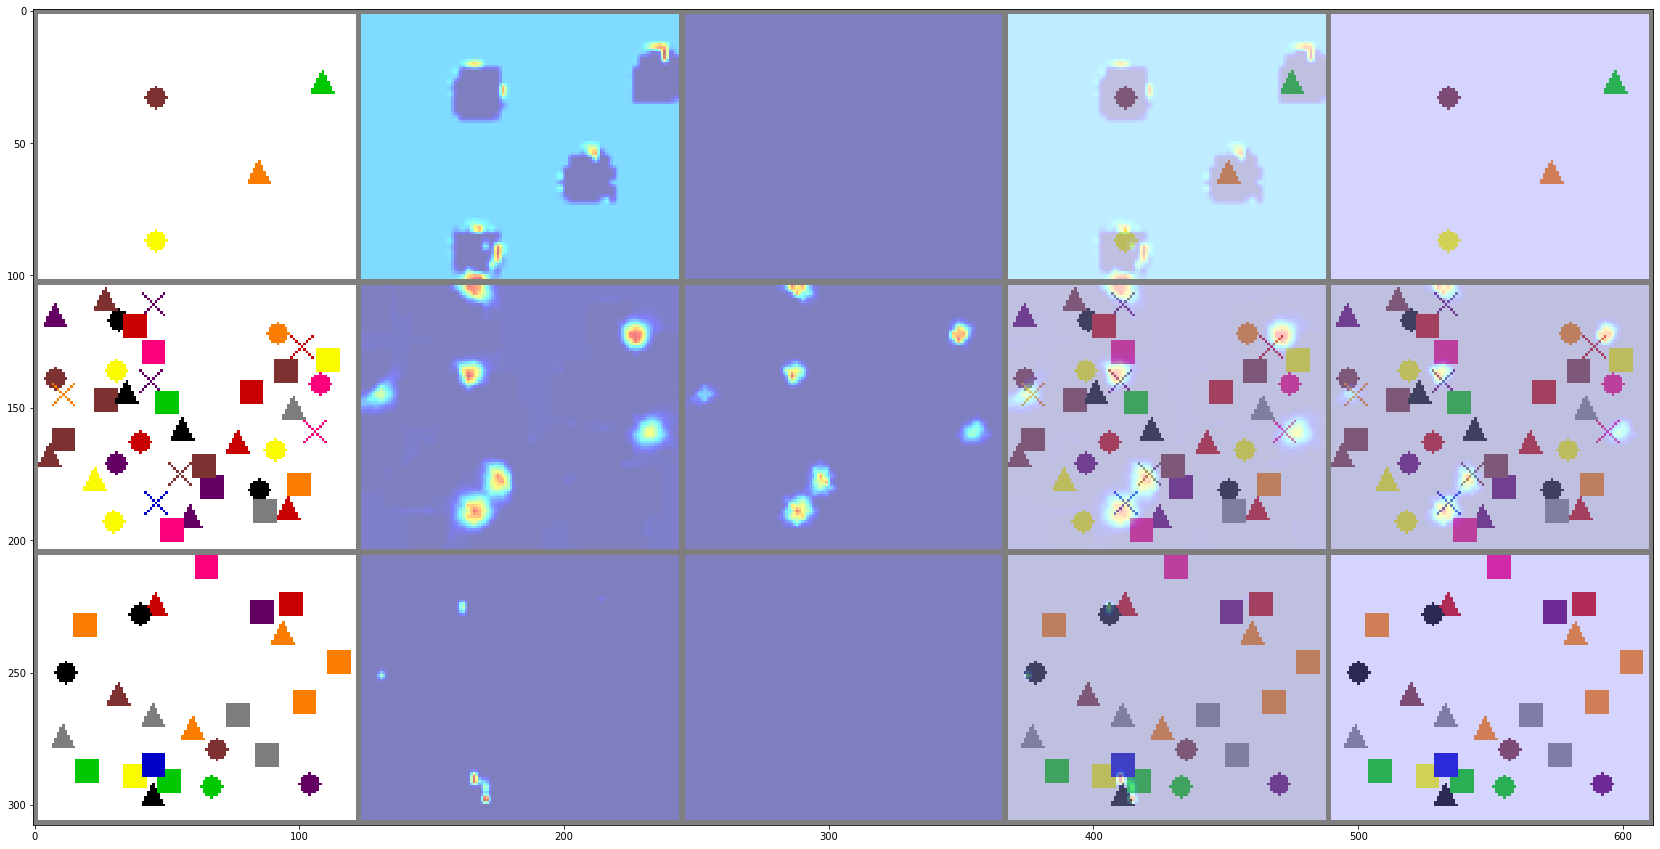

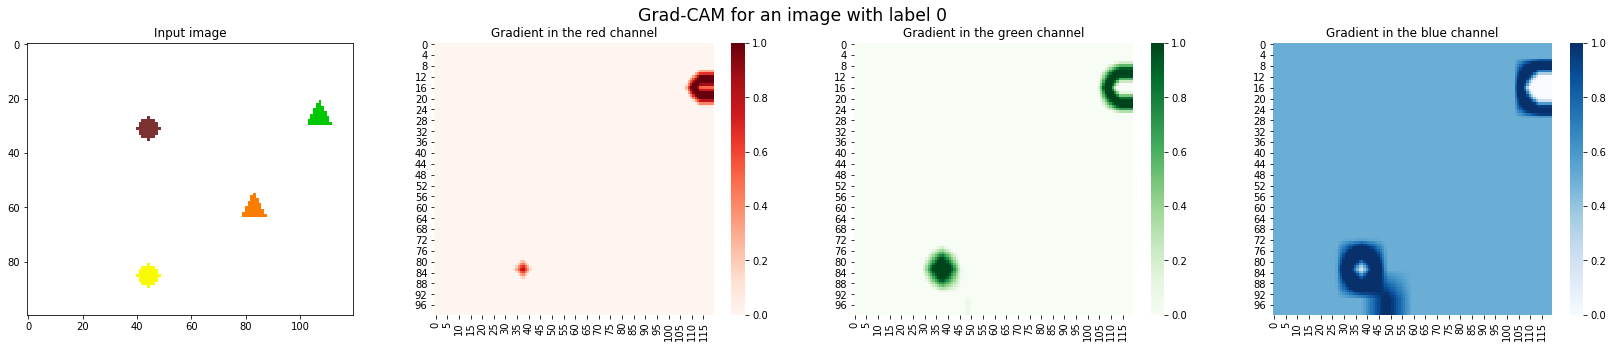

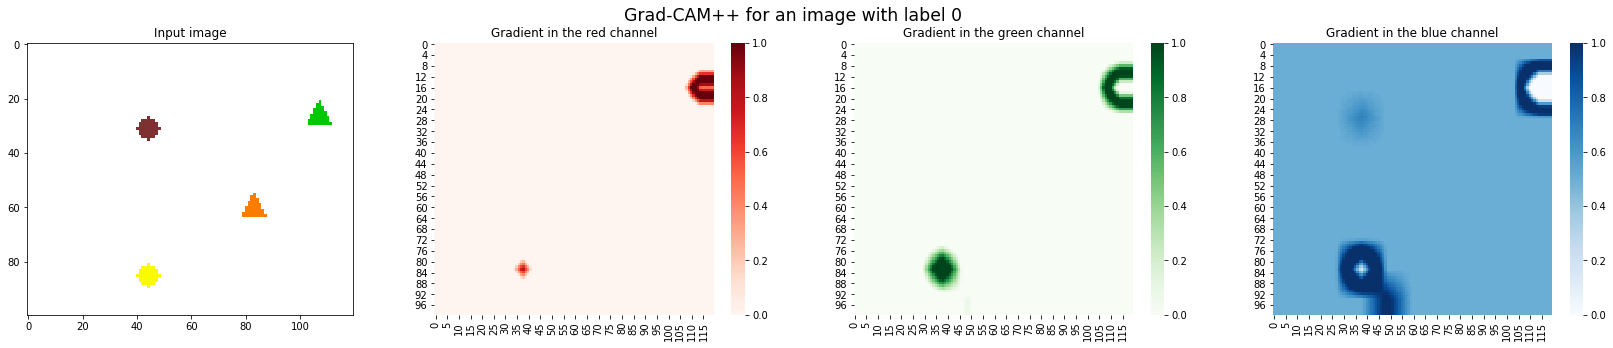

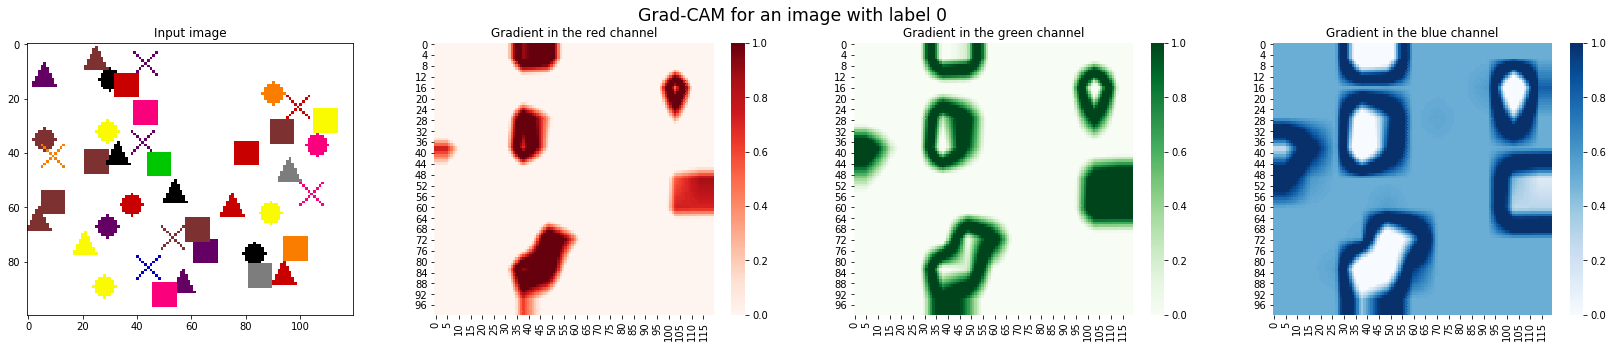

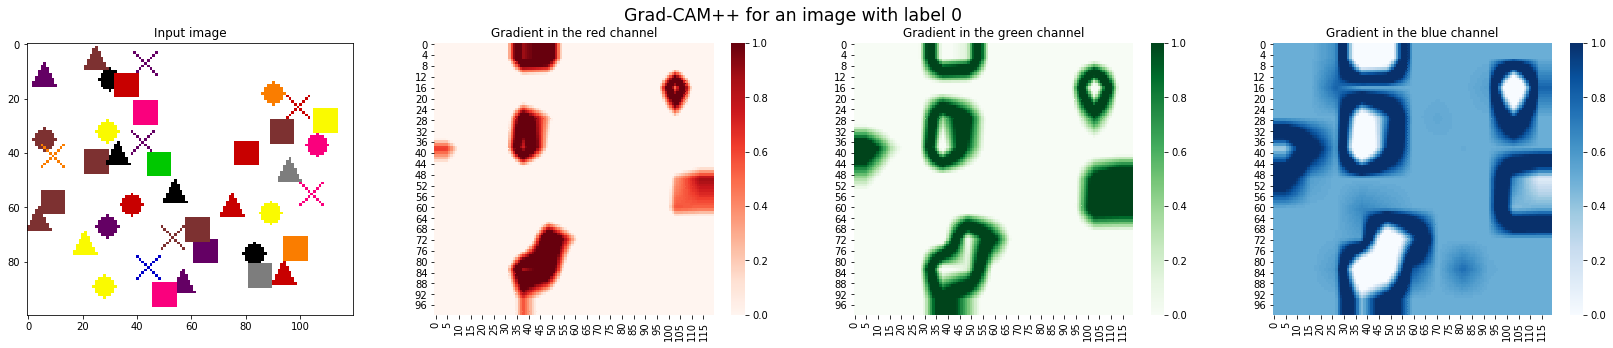

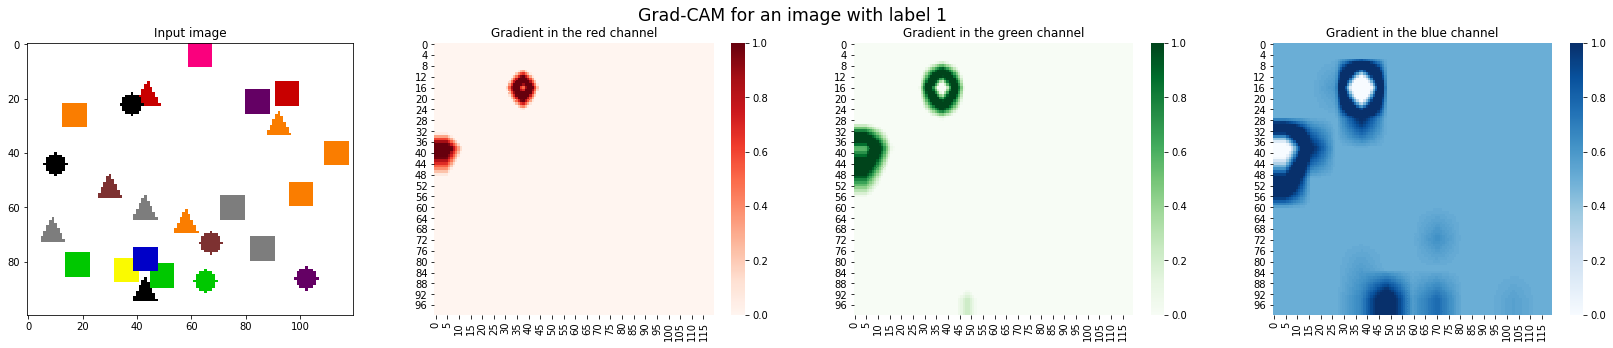

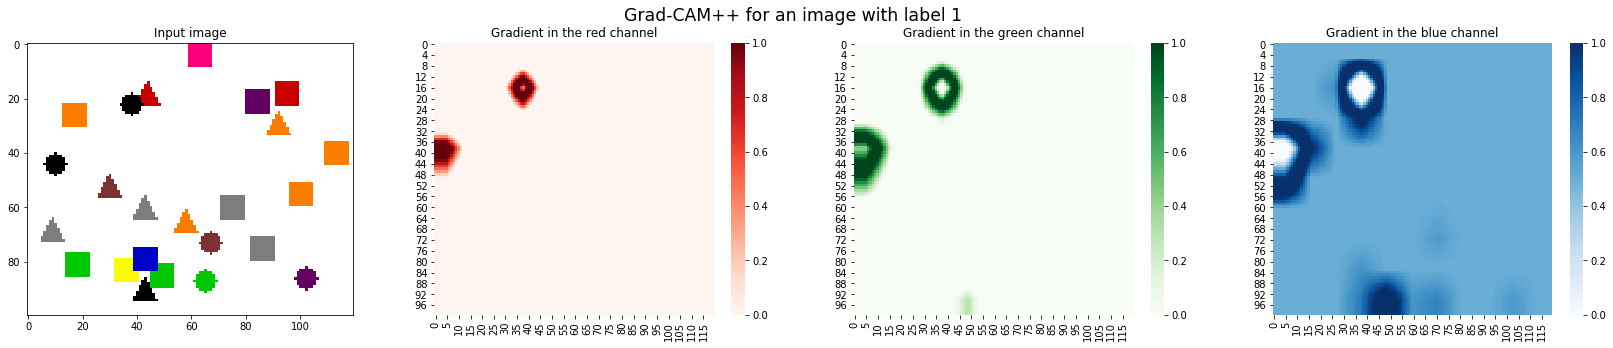

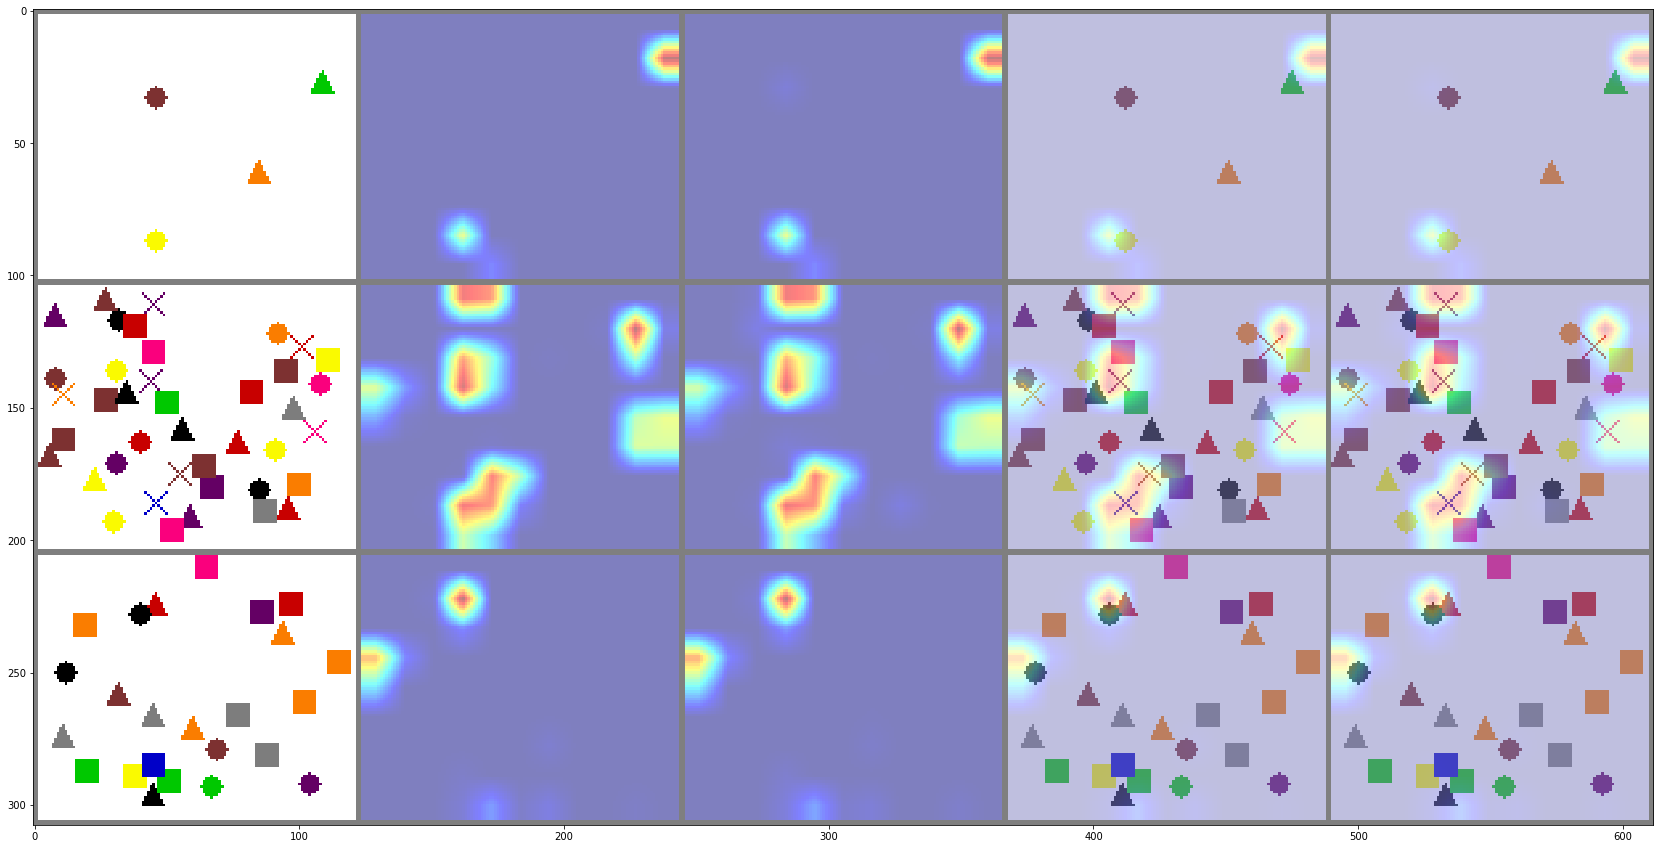

In [18]:
layers = [net.conv2, net.pool2]
names = ["Second convolutional layer", "Second pooling layer"]

for i in range(len(layers)): 
  target_layer = layers[i]
  gradcam = GradCAM(net, target_layer)
  gradcam_pp = GradCAMpp(net, target_layer)

  mask0, _ = gradcam(input0)
  heatmap0, result0 = visualize_cam(mask0, input0)
  mask_pp0, _ = gradcam_pp(input0)
  heatmap_pp0, result_pp0 = visualize_cam(mask_pp0, input0)

  mask1, _ = gradcam(input1)
  heatmap1, result1 = visualize_cam(mask1, input1)
  mask_pp1, _ = gradcam_pp(input1)
  heatmap_pp1, result_pp1 = visualize_cam(mask_pp1, input1)

  mask2, _ = gradcam(input2)
  heatmap2, result2 = visualize_cam(mask2, input2)
  mask_pp2, _ = gradcam_pp(input2)
  heatmap_pp2, result_pp2 = visualize_cam(mask_pp2, input2)

  print(names[i])
  intp.display_gradients(img0, heatmap0.detach().numpy()).suptitle("Grad-CAM for an image with label 0", size="xx-large")
  intp.display_gradients(img0, heatmap_pp0.detach().numpy()).suptitle("Grad-CAM++ for an image with label 0", size="xx-large")
  intp.display_gradients(img1, heatmap1.detach().numpy()).suptitle("Grad-CAM for an image with label 0", size="xx-large")
  intp.display_gradients(img1, heatmap_pp1.detach().numpy()).suptitle("Grad-CAM++ for an image with label 0", size="xx-large")
  intp.display_gradients(img2, heatmap2.detach().numpy()).suptitle("Grad-CAM for an image with label 1", size="xx-large")
  intp.display_gradients(img2, heatmap_pp2.detach().numpy()).suptitle("Grad-CAM++ for an image with label 1", size="xx-large")

  I = []
  I.extend([image0, heatmap0, heatmap_pp0, result0, result_pp0])
  I.extend([image1, heatmap1, heatmap_pp1, result1, result_pp1])
  I.extend([image2, heatmap2, heatmap_pp2, result2, result_pp2])


  grid_image = make_grid(I, nrow=5)

  fig, ax = plt.subplots(figsize=(5*FIGSIZE[0], 3*FIGSIZE[1]))
  ax.imshow(utils.input2image((grid_image.detach()), MEAN, STD))

NEWINPUT
predicted class ids 0	 probability 0.9988045692443848
predicted class ids 0	 probability 0.9988045692443848
predicted class ids 0	 probability 0.9989317059516907
NEWINPUT
predicted class ids 0	 probability 1.0
predicted class ids 0	 probability 1.0
predicted class ids 0	 probability 1.0
NEWINPUT
predicted class ids 1	 probability 1.0
predicted class ids 1	 probability 1.0
predicted class ids 1	 probability 1.0


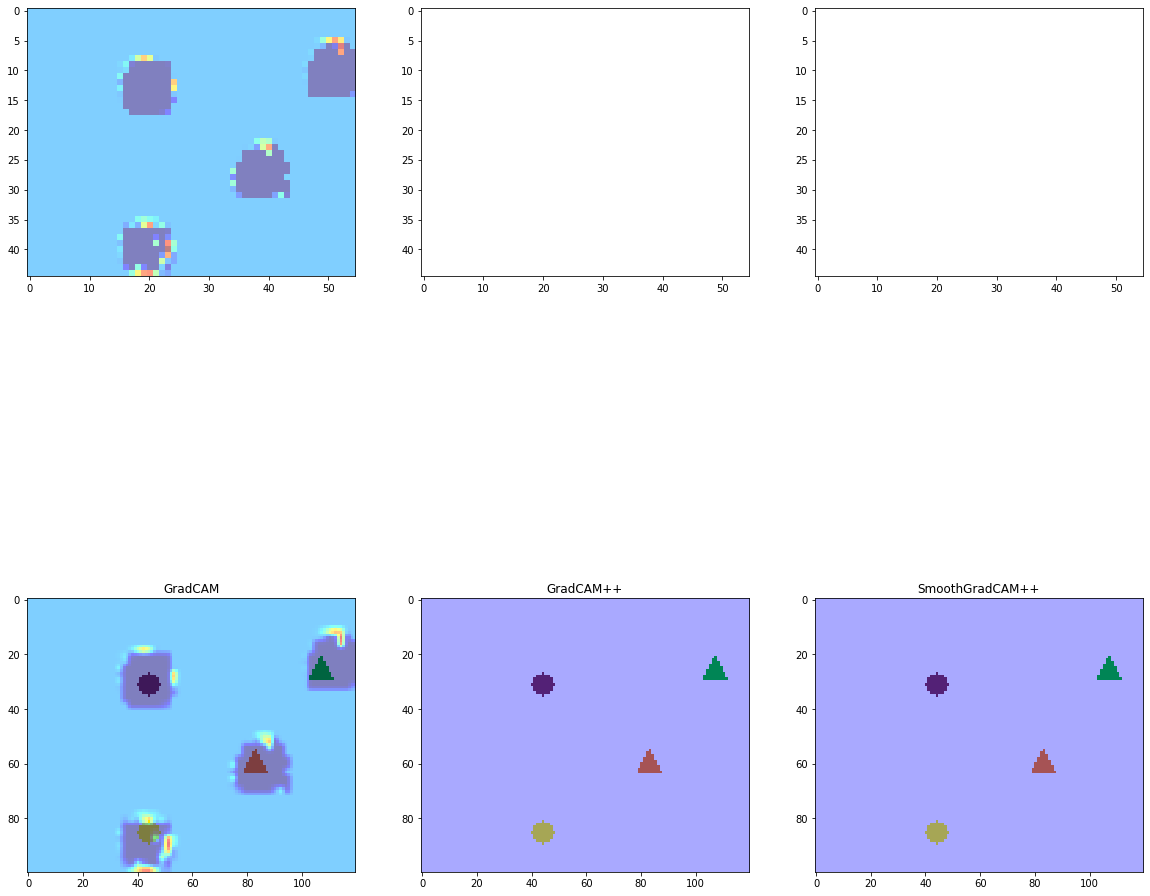

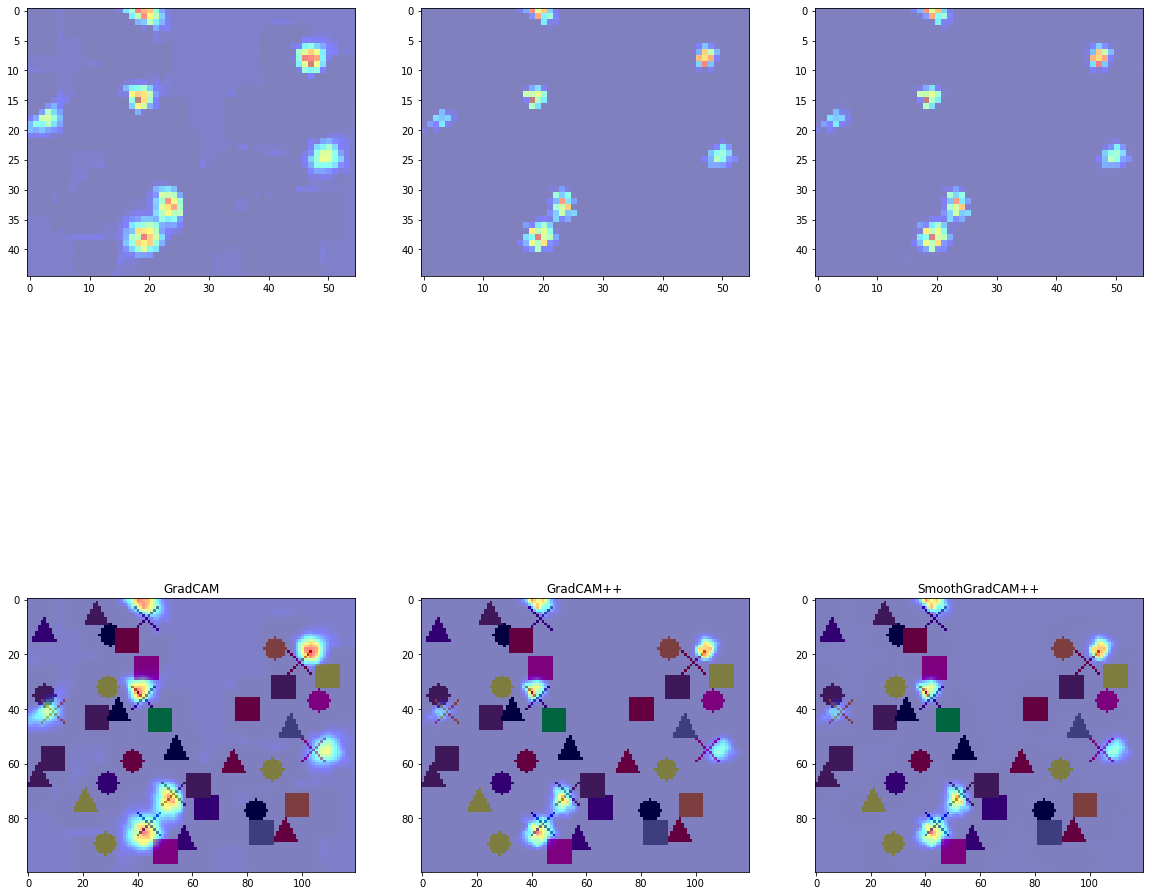

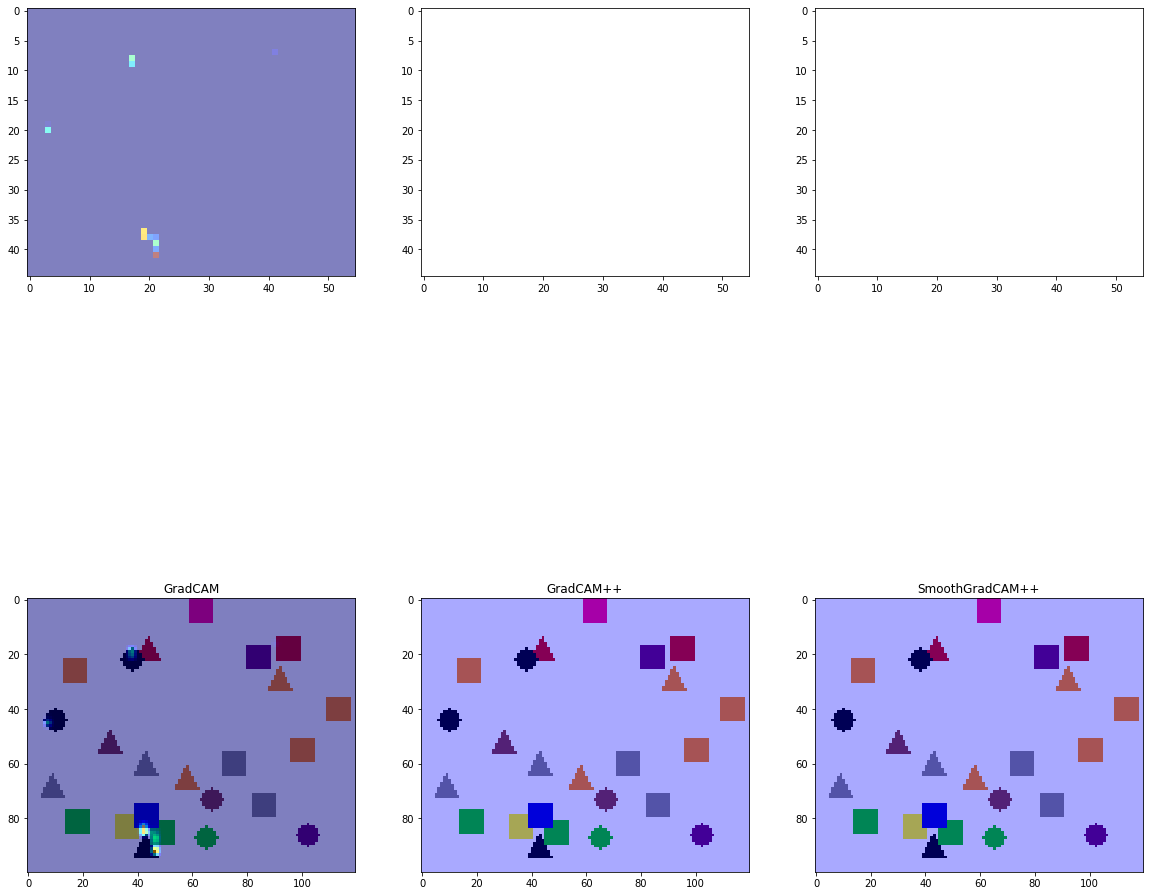

In [19]:
target_layer = net.conv2
wrapped_G = smooth.GradCAM(net, target_layer)
wrapped_P = smooth.GradCAMpp(net, target_layer)
wrapped_S = smooth.SmoothGradCAMpp(net, target_layer, n_samples=25, stdev_spread=0.15)
wrapped = [wrapped_G, wrapped_P, wrapped_S]
titles = ["GradCAM","GradCAM++","SmoothGradCAM++"]
for inp in [input0, input1, input2]: 
  print("NEWINPUT")
  fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,20))
  for i in range(len(wrapped)): 
    cam, idx = wrapped[i](inp)
    img = inp.clone()
    img[0,0,:,:] *= STD[0]
    img[0,0,:,:] += MEAN[0]
    img[0,1,:,:] *= STD[1]
    img[0,1,:,:] += MEAN[1]
    img[0,2,:,:] *= STD[2]
    img[0,2,:,:] += MEAN[2]
    heatmap = visualize(img, cam)
    hm = (heatmap.squeeze().detach().numpy().transpose(1, 2, 0))
    ax[0][i].imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')
    ax[1][i].imshow(hm)
    ax[1][i].set_title(titles[i])

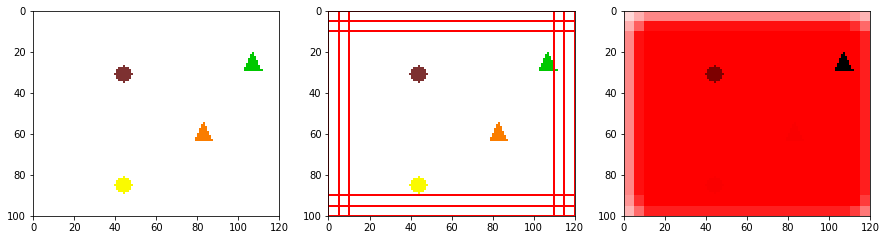

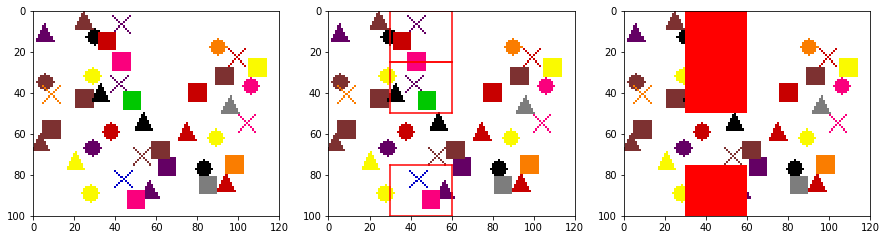

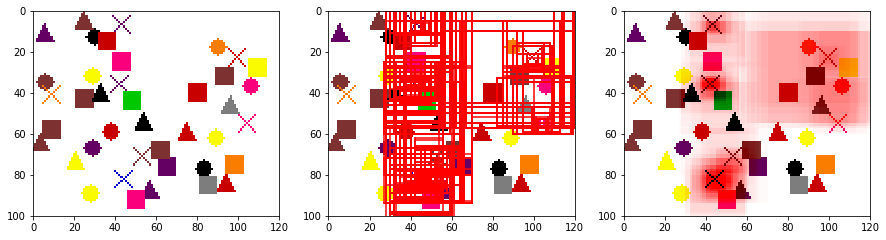

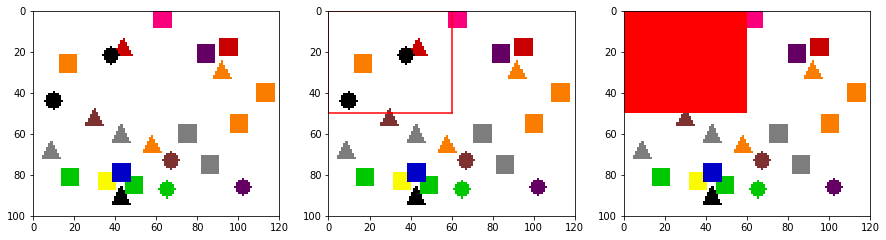

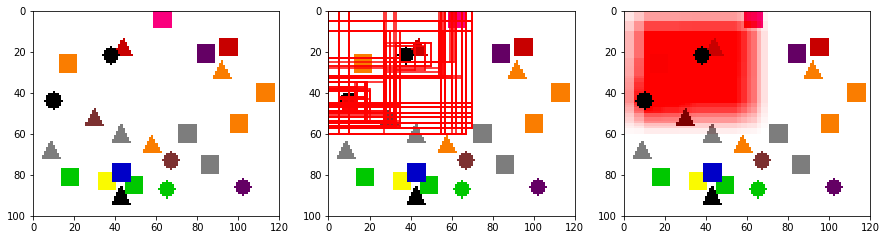

In [21]:
h = HS.HierarchicalShap(net)
h.shapMap(image0, label0, shapTol = [5,5.5,6,6.5,7])
h.shapMap(image1, label1, shapTol = [6], keepItSimple = True)
h.shapMap(image1, label1, shapTol = [5,5.5,6,6.5,7])
h.shapMap(image2, label2, shapTol = [6], keepItSimple = True)
h.shapMap(image2, label2, shapTol = [5,5.5,6,6.5,7])